# Global settings

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


import nltk
import codecs

#from nltk.corpus.reader.api import CorpusReader
#from nltk.corpus.reader.api import CategorizedCorpusReader

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

import pandas_profiling

from bs4 import BeautifulSoup

from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

DATA_PATH = os.path.join("datasets", "stackexchange")
#DATA_PATH = os.path.join(DATA_PATH, "out")

#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults_20190101-20200620.csv")
#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults 20200301-20200620_1.csv")

DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]


plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ6.pickle'


/home/francois/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
ALL_FILES_LIST

['datasets/stackexchange/QueryResults 20190101-20190228_6.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_5.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_1.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_2.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_4.csv',
 'datasets/stackexchange/QueryResults 20190101-20190228_3.csv']

# Load data

In [3]:
import pandas as pd

pd.set_option('display.max_columns', None)

feats_list = ['Title', 'Body', 'Tags']

def load_data(data_path=DATA_PATH):
    csv_path = DATA_PATH_FILE
    df_list = []
    
    for f in ALL_FILES_LIST:
        print(f'Loading file {f}')
        
        df_list.append(pd.read_csv(f, sep=',', header=0, encoding='utf-8', usecols=feats_list))
        
    return pd.concat(df_list)


In [4]:
df = load_data()
df.reset_index(inplace=True)

Loading file datasets/stackexchange/QueryResults 20190101-20190228_6.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_5.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_1.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_2.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_4.csv
Loading file datasets/stackexchange/QueryResults 20190101-20190228_3.csv


In [5]:
df

,index,Body,Title,Tags
0,0,"<p>The <a href=""https://developer.mozilla.org/...",Is there any way to inspect ::first-line and :...,<css><developer-tools>
1,1,<p>I have a property injected like so:</p>\n\n...,How to track changes to the injected root inst...,<vue.js>
2,2,<p>so I'm trying to get this cloud query funct...,Parse Cloud Code - Await and return relation q...,<javascript><parse-server><parse-cloud>
3,3,<p>I need help with making some IF/OR/AND stat...,complex IF statements with multiple variables ...,<excel><if-statement><excel-formula>
4,4,<p>What is wrong with this filter? </p>\n\n<pr...,Active Directory userAccountcontrol multiple v...,<filter><active-directory>
...,...,...,...,...
299995,49995,<p>I need to input filed value in application ...,Xpath to match case sensitive of multiple strings,<selenium><xpath><xpath-1.0>
299996,49996,<p>I'm trying to do a basic test using Seleniu...,Using Selenium Grid to run Safari on MacOS Mojave,<java><selenium><selenium-webdriver><selenium-...
299997,49997,"<p>Briefly, I'm parsing HTTP headers, received...","c, trimming strings, and wide characters",<c><trim><widechar><widestring>
299998,49998,<p>Context: I'm a student who just finished an...,Operating systems vs. database management systems,<database><operating-system>


## Drop NA on body and remove html tags

In [6]:
df.dropna(subset=['Body'], axis=0, inplace=True)

In [7]:
# Manually with a regexp
#df.loc[:, 'Body'] = df['Body'].str.replace('<[^<]+?>', '') 

In [8]:
# Or with beautifulsoup
df.loc[:, 'Body'] = df['Body'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [9]:
df

,index,Body,Title,Tags
0,0,The ::first-line and ::first-letter pseudo-ele...,Is there any way to inspect ::first-line and :...,<css><developer-tools>
1,1,I have a property injected like so:\nVue.proto...,How to track changes to the injected root inst...,<vue.js>
2,2,so I'm trying to get this cloud query function...,Parse Cloud Code - Await and return relation q...,<javascript><parse-server><parse-cloud>
3,3,I need help with making some IF/OR/AND stateme...,complex IF statements with multiple variables ...,<excel><if-statement><excel-formula>
4,4,What is wrong with this filter? \n(&(objectCla...,Active Directory userAccountcontrol multiple v...,<filter><active-directory>
...,...,...,...,...
299995,49995,I need to input filed value in application and...,Xpath to match case sensitive of multiple strings,<selenium><xpath><xpath-1.0>
299996,49996,I'm trying to do a basic test using Selenium G...,Using Selenium Grid to run Safari on MacOS Mojave,<java><selenium><selenium-webdriver><selenium-...
299997,49997,"Briefly, I'm parsing HTTP headers, received fr...","c, trimming strings, and wide characters",<c><trim><widechar><widestring>
299998,49998,Context: I'm a student who just finished an op...,Operating systems vs. database management systems,<database><operating-system>


In [10]:
print(df['Body'].loc[0])

The ::first-line and ::first-letter pseudo-elements, as their names suggest, allow you to style the first letter and first line of an HTML element.
However, I can't find any way to inspect these styles in a browser's developer tools. Other pseudo-elements and pseudo-classes (like ::before, ::after, :first-child, etc) are readily inspectable in dev tools via "Inspect element", but I can't find a way to inspect ::first-letter or ::first-line. Is there a way that I'm missing, or is this not currently possible?



In [11]:
print(df['Body'].loc[10000])

Can I declare globals in a subroutine in perl with use strict?
Consider the following code:
#!/usr/bin/perl
# $Id: foo,v 1.5 2019/02/21 10:41:08 bennett Exp bennett $

use strict;
use warnings;

initialize();

print "$lorem\n";

exit 0;

sub initialize {
    # How would one delcare "$lorem" here such that it is available as
    # a global?

    $lorem = <<_EOM_
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
_EOM_
    ;
}

Note that I'm not asking if (ab)using globals in this fashion is a good idea;  I'm certain that it isn't.
I've tried a few combinations of our and $main::, but they all fa

In [12]:
print(df['Body'].loc[100000])

I am working on a program that will read data from a data source, and publish that data as it is read. I have a reader and a writer, the reader spawns several threads to read all the data it needs to read, puts the data into a queue, and the writer reads the data from the queue an publishes it.
I have a controller for my readers and a controller for my writers. The controllers implement the Callable interface, but could implement the Runnable interface as my call return is Void.
I want to use an executor to run the two controllers. The reader controller will need to be invoked every X minutes (and X is greater than the time it takes the controller to run).
Right now, I am creating a list of Callables, sending them to an ExecutorService that is:
List<Future<Void>> futures = ExecutorService es = new Executors.newFixedThreadPoll(2);
for(Future<Void> future: futures) {
    try {
        future.get();
    } catch (Exception e) {
        // log the error
    }
}

How can I turn this into a s

In [13]:
print(df[df['Body'].str.contains('html')]['Body'].iloc[2])

I'm receiving a data from AJAX response and I'm trying to update a jQuery plugin with that value in the success callback:
$.ajax({
   url: '/some/url',
   type: 'GET',
   dataType: 'json',
   success: (data) => {
      $(".my-rating").starRating('setRating', data.rating);
   }
});

I'm using the star-rating-svg plugin to show ratigns (http://nashio.github.io/star-rating-svg/demo/). The problem is that I'm having an error:

Uncaught TypeError: $(...).starRating is not a function

However, this function works perfectly when is called outside AJAX callback. Do you know how to deal with this?
EDIT:
Larger piece of my code:
show.ejs
<!DOCTYPE html>
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css">
    <script src="https://code.jquery.com/jquery-3.3.1.min.js"></script>
    <script type="text/javascript" src="/star-svg/src/jquery.star-rating-svg.js"></script>
    <link rel="stylesheet" type="text/css" href="/star-svg

In [14]:
# Converting tags from <tag 1><tag2><tag3> to tag1 tag2 tag3
df.loc[:, 'Tags'] = df['Tags'].str.replace('<', '') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.replace('>', ' ') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.rstrip()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299798 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   299798 non-null  int64 
 1   Body    299798 non-null  object
 2   Title   299144 non-null  object
 3   Tags    299144 non-null  object
dtypes: int64(1), object(3)
memory usage: 21.4+ MB


In [16]:
df.sample(100)

,index,Body,Title,Tags
166398,16398,in a java-kotlin hybrid using Android Studio 3...,Android Studio 3.3: New Gradle Sync is not sup...,android android-studio gradle kotlin
206961,6961,It looks like I cannot connect to my free Mong...,Error: querySrv ENODATA _mongodb._tcp.blog-clu...,javascript node.js database mongodb mongodb-atlas
195086,45086,"\nreading bulk CSV_FILE, i have no problem if ...",use pandas to handle massive csv file,python python-3.x pandas pandas-groupby chunking
21043,21043,In my project users upload images into a S3 bu...,Connecting S3 - Lambda - EC2 - Elasticsearch,amazon-web-services tensorflow elasticsearch a...
50387,387,I'm still learning java and finding it pretty ...,How to use only certain class object values in...,java function class oop
135349,35349,I want to get my current location in django so...,Django- How to get my current location in django,python django django-rest-framework
108880,8880,I've a question how exactly docker-compose han...,Wordpress container just works default credent...,wordpress docker docker-compose
55912,5912,I am trying to sort my user scores. It works w...,Collection sort throws exception,java spring scala spring-boot kotlin
290704,40704,I am a complete beginner in django and django ...,How to get response from django rest api in js...,python json django jsend
133763,33763,Beginner programmer here:)) I am working on a ...,While loops inside an if-statement?,python python-3.x function if-statement while-...


In [17]:
df

,index,Body,Title,Tags
0,0,The ::first-line and ::first-letter pseudo-ele...,Is there any way to inspect ::first-line and :...,css developer-tools
1,1,I have a property injected like so:\nVue.proto...,How to track changes to the injected root inst...,vue.js
2,2,so I'm trying to get this cloud query function...,Parse Cloud Code - Await and return relation q...,javascript parse-server parse-cloud
3,3,I need help with making some IF/OR/AND stateme...,complex IF statements with multiple variables ...,excel if-statement excel-formula
4,4,What is wrong with this filter? \n(&(objectCla...,Active Directory userAccountcontrol multiple v...,filter active-directory
...,...,...,...,...
299995,49995,I need to input filed value in application and...,Xpath to match case sensitive of multiple strings,selenium xpath xpath-1.0
299996,49996,I'm trying to do a basic test using Selenium G...,Using Selenium Grid to run Safari on MacOS Mojave,java selenium selenium-webdriver selenium-grid...
299997,49997,"Briefly, I'm parsing HTTP headers, received fr...","c, trimming strings, and wide characters",c trim widechar widestring
299998,49998,Context: I'm a student who just finished an op...,Operating systems vs. database management systems,database operating-system


# Global counts

In [ ]:
df

In [ ]:
#pandas_profiling.ProfileReport(df)

## Tokens and vocabulary count

In [ ]:
counts_body  = nltk.FreqDist()
tokens_body  = nltk.FreqDist()

for post in df.loc[:, 'Body']:
    for word in wordpunct_tokenize(post):
        counts_body['words'] += 1
        tokens_body[word] += 1
        
print('Counts for body text')
print('Number of tokens : ' + str(counts_body['words']))
print('Number of distinct tokens (vocabulary): ' + str(len(tokens_body)))

In [ ]:
counts_tags  = nltk.FreqDist()
tokens_tags  = nltk.FreqDist()

for tag_line in df.dropna(subset=['Tags'], axis=0)['Tags']:
    for word in tag_line.split(' '):
        counts_tags['words'] += 1
        tokens_tags[word] += 1
        
print('Counts for tags')
print('Number of tokens : ' + str(counts_tags['words']))
print('Number of distinct tokens (vocabulary): ' + str(len(tokens_tags)))

In [ ]:
#for token in tokens_tags:
#    print(token)

## Most represented tags

In [23]:
{k: v for k, v in sorted(tokens_tags.items(), key=lambda item: item[1], reverse=True)}

{'python': 34619,
 'javascript': 31805,
 'java': 22234,
 'c#': 17234,
 'android': 14944,
 'php': 14732,
 'html': 13084,
 'python-3.x': 9313,
 'reactjs': 8992,
 'css': 8824,
 'angular': 8745,
 'sql': 8281,
 'r': 8213,
 'node.js': 8011,
 'c++': 7708,
 'jquery': 7036,
 'mysql': 7003,
 'pandas': 5756,
 'ios': 5672,
 'swift': 5627,
 'arrays': 5034,
 'excel': 4776,
 'typescript': 4723,
 'sql-server': 4706,
 'django': 4540,
 'json': 4520,
 'laravel': 4423,
 'c': 4391,
 'vba': 3696,
 'react-native': 3457,
 'spring-boot': 3454,
 'firebase': 3317,
 'regex': 3006,
 'spring': 2979,
 'docker': 2946,
 'amazon-web-services': 2840,
 'vue.js': 2825,
 'wordpress': 2666,
 'flutter': 2631,
 'ruby-on-rails': 2569,
 '.net': 2509,
 'azure': 2484,
 'mongodb': 2454,
 'postgresql': 2379,
 'dataframe': 2378,
 'asp.net': 2186,
 'database': 2139,
 'bash': 2072,
 'tensorflow': 2051,
 'kotlin': 2041,
 'git': 2027,
 'ajax': 2008,
 'linux': 2005,
 'numpy': 1981,
 'oracle': 1932,
 'asp.net-core': 1874,
 'powershell': 1

# Cumulated number of posts against tags

In [24]:
tags_represented_posts_cumulated = np.cumsum([v for k, v in sorted(tokens_tags.items(), key=lambda item: item[1], reverse=True)])

In [25]:
tags_represented_posts_cumulated.max()

866719

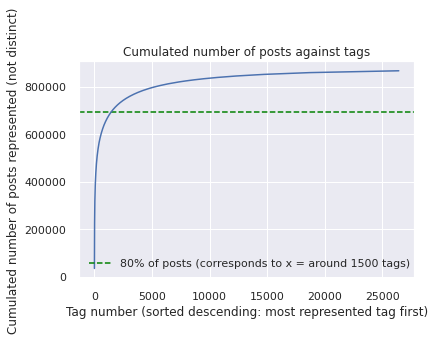

In [26]:
plt.title('Cumulated number of posts against tags')
plt.xlabel('Tag number (sorted descending: most represented tag first)')
plt.ylabel('Cumulated number of posts represented (not distinct)')
plt.axhline(tags_represented_posts_cumulated.max() * 0.80, color='green', linestyle='--', label=f"80% of posts (corresponds to x = around 1500 tags)")
plt.legend()
plt.plot(range(len(tags_represented_posts_cumulated)), tags_represented_posts_cumulated)

In [27]:
tags_represented_posts_cumulated[1500]

696337

# Frequency visualisation of tokens

In [37]:
#vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b") # this token pattern overrides default of min 2 letters for a word
#vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'") # Allows 1 word tokens like !, ?, ", '
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(df['Body'])

In [38]:
plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

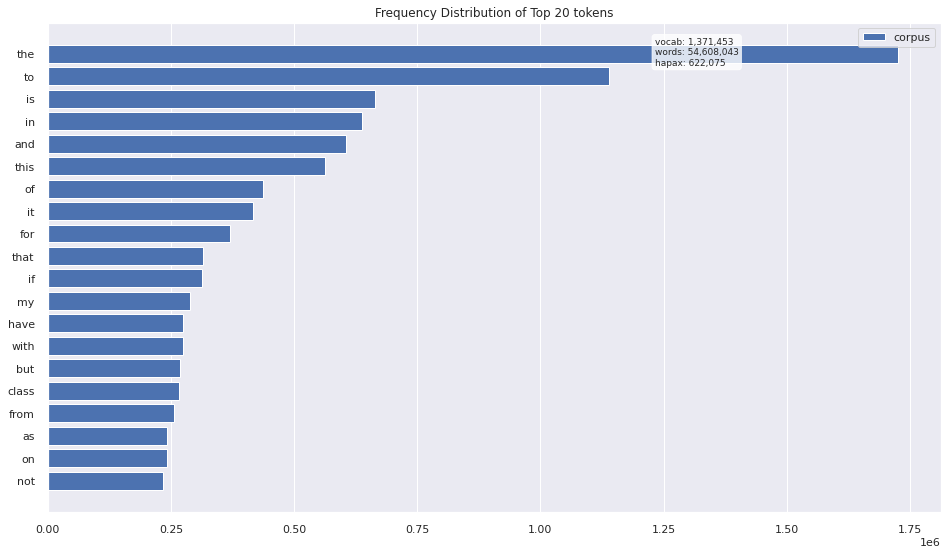

In [39]:
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(docs)
visualizer.poof()


In [40]:
#vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w+\b") # this token pattern overrides default of min 2 letters for a word
#vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'") # Allows 1 word tokens like !, ?, ", '
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(df['Body'])

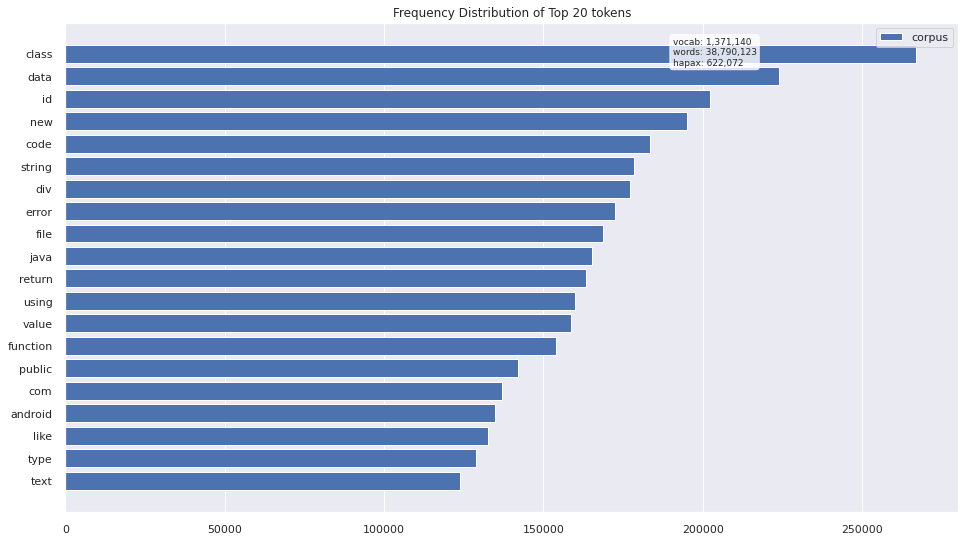

In [41]:
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(docs)
visualizer.poof()

In [22]:
docs

<299798x1371140 sparse matrix of type '<class 'numpy.int64'>'
	with 18679310 stored elements in Compressed Sparse Row format>

In [23]:
np.min([len(f) for f in features])

2

## Most represented tokens

In [34]:
{k: v for k, v in sorted(tokens_body.items(), key=lambda item: item[1], reverse=True)}

{'.': 6049669,
 ',': 2289834,
 ':': 2175332,
 '(': 1916654,
 '-': 1623569,
 'the': 1587219,
 '"': 1352271,
 '=': 1342844,
 'I': 1292574,
 '/': 1179854,
 'to': 1124327,
 "'": 1047961,
 ')': 952216,
 'a': 786851,
 '{': 780943,
 '>': 711363,
 '0': 668393,
 '<': 666232,
 '}': 652153,
 ';': 626144,
 'is': 616724,
 'in': 589060,
 'and': 564106,
 '1': 563492,
 '="': 561011,
 'this': 490822,
 'of': 433796,
 'it': 377800,
 '[': 371780,
 '</': 344791,
 'for': 338372,
 ');': 337984,
 '",': 327242,
 'that': 310112,
 '2': 304640,
 'have': 273577,
 '$': 268744,
 '\\': 264726,
 '?': 264572,
 'with': 264085,
 'i': 260791,
 'if': 260121,
 'class': 259637,
 '()': 247264,
 'my': 242519,
 'from': 230554,
 'on': 224546,
 '("': 218331,
 'not': 218253,
 "',": 215084,
 'but': 214343,
 ']': 212486,
 'data': 207702,
 '":': 207253,
 'at': 204069,
 '3': 200687,
 'as': 195955,
 '|': 189633,
 '//': 186162,
 'new': 184914,
 '+': 182225,
 'div': 176156,
 'name': 173447,
 'be': 173061,
 't': 170164,
 'code': 169400,
 

# Annex

## Distinct tags covered against post numbers

cnt_docs = 0
cnt_nulltags = 0

cnt_distinct_tags_history = []
cnt_distinct_tags_current = 0

tokens_tags = nltk.FreqDist()

for tag_line in df['Tags']:
    '''
    if (cnt_docs < 10):
        print(tag_line)
        print(type(tag_line))
    '''
    
    if (str(tag_line) == 'nan'):
        cnt_nulltags +=1
    
    else:
        for word in tag_line.split():
            if (tokens_tags[word] == 0):
                cnt_distinct_tags_current += 1
                
            tokens_tags[word] += 1    
        
    cnt_distinct_tags_history.append(cnt_distinct_tags_current)
    
    cnt_docs += 1

plt.title('Cumulated number of distinct tags against post numbers')
plt.xlabel('Post ID')
plt.ylabel('Cumulated number of distinct tags represented')
plt.plot(range(cnt_docs), cnt_distinct_tags_history)